In [1]:
%pylab inline
import sys
import pandas as pd
import numpy as np
import datetime
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from yahoo_finance import Share
import pandas.io.data as web
import seaborn

Populating the interactive namespace from numpy and matplotlib


# A New Approach

Over the past few months we have worked on several trading strategies all based around one concept: reversion. The assumption that allows us to confidently pursue this is that price variance is larger in the short term than long term. Thus prices are best modeled as a random walk plus noise. We apply kalman filters to reduce the noise so that we can use statistical arbitrage to make successful trading strategies.

In practice, however, the idea is more complicated. How much noise is there? Is the noise a sort of oscilation from above the true value to below or is it white noise? How should we use the data to execute trades? Initially we let our intuition and the results of experiments answer these questions. We had several choices for trade logic, we varied the Q and R values of the kalman filter to have it at different levels of smoothness. By varying these things, we were representing the amount of noise and its stochastic distribution in completely different ways and hoping to optimize to the correct value.

By examining the variance ratio, I hope to answer these questions in a more mathematical way. 

### Intuition: Modeling With Fake Data

Before I look at real data, I will make a model of my intuitive picture of this trade. This will allow us to see what parameters we must work within. More specifically, I hope to answer what is the minimum level of noise that our kalman filter can filter so that we can still use statistical arbitrage.  

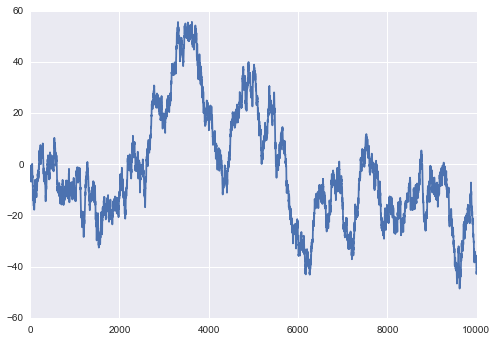

In [423]:
#I create a random walk, ts. It is the cumulative sum of a sample of normal distribution with standard deviation 1

ts = []
for i in range(10000):
    ts.append(np.random.normal(scale=1))
    
ts = pd.DataFrame(np.cumsum(ts))

plot(ts)

Here is a plot of the standard deviations of the motion of ts 
(i.e. ts[i] - ts[i + t] for values of t from 1 to 100)

Note that the standard deviation barely changes. Its stays right at 1, which is what we set the "scale" variable in our normal distribution.

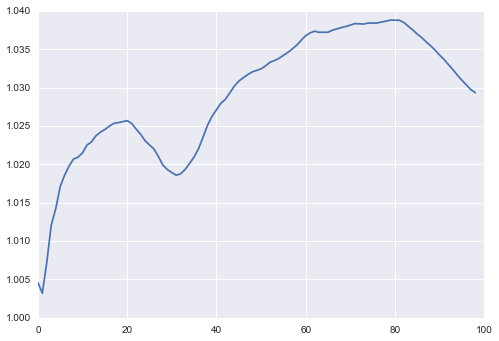

In [424]:
stds = []
for i in range(1, 100):
    stds.append(np.std(ts- ts.shift(i)) * np.sqrt(1/i))
plot(stds)

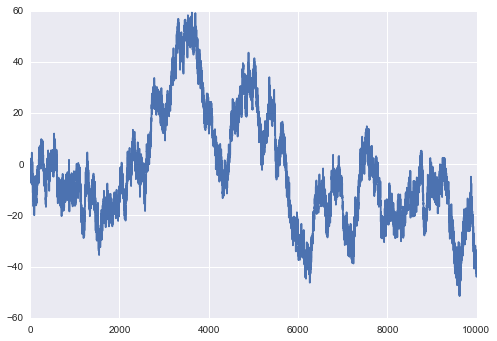

In [425]:
# I add noise. I use normal distribution with standard deviation of 1

noise = []
for i in range(10000):
    noise.append(np.random.normal(scale = 2))
noise= pd.DataFrame(noise)

ts2 = ts + pd.DataFrame(noise)

plot(ts2)

Now the variance decays from short term to long term, as we expected:

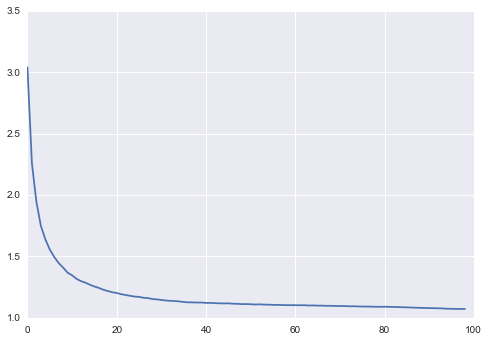

In [426]:
stds = []
for i in range(1, 100):
    stds.append(np.std(ts2- ts2.shift(i)) * np.sqrt(1/i))
plot(stds)

I apply a kalman filter. Notice how the filter is very close to the original values because of the Q and R that I chose. This is because I am only looking for single day deviations, rather than longer term. 

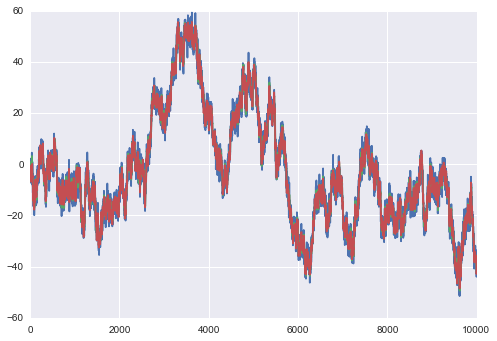

In [429]:
kf=KalmanFilter(transition_matrices=[[1,1],[0,1]],observation_matrices=[[1,0]],
                initial_state_mean=[0,0],transition_covariance=[[.001,0],[0,.001]],
                observation_covariance=1) #TC -> Q ;; OC -> R
# kf=kf.em(prices,n_iter=5)
(a,b)=kf.filter(ts2)

plot(ts2)
plot(a[:,0])
plot(ts)


In [430]:
#trade logic is to put on a trade when the residual is outside of a threshold, 
    # defined as one standard deviation of the residual's distribution

test_data = pd.DataFrame(ts)
test_data.columns = ['random_walk']
test_data['noise'] = noise
test_data['signal'] = ts2
test_data['filter'] = a[:,0]
test_data['resids'] = test_data.signal - test_data['filter']
test_data['position'] = 0
resid_dev = np.std(test_data.resids)
test_data.position[test_data.resids<-resid_dev] = 1
test_data.position[test_data.resids>resid_dev] = -1
test_data['daily_diff'] = test_data.signal.shift(-1) - test_data.signal
test_data['results'] = test_data.position * test_data.daily_diff

/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


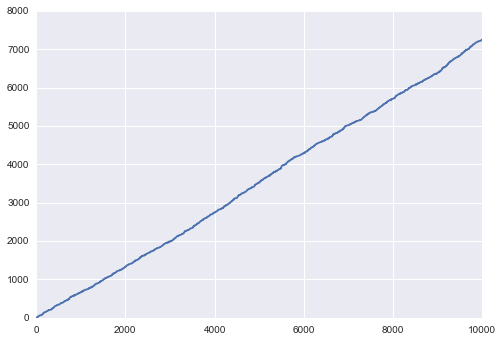

In [431]:
plot(np.cumsum(test_data.results))

So those are great results, but it was too easy since we had so much noise. Here I chopped all that down into one function, so we can play with the amount of noise.

In [495]:
def play_with_noise(noise_, length = 10000):
    ts = []
    for i in range(length):
        ts.append(np.random.normal(scale=10))

    ts = pd.DataFrame(np.cumsum(ts))
    stds = []
    for i in range(1, 100):
        stds.append(np.std(ts- ts.shift(i)) * np.sqrt(1/i))
    noise = []
    for i in range(length):
        noise.append(np.random.normal(scale = noise_*10))
    noise= pd.DataFrame(noise)
    ts2 = ts + pd.DataFrame(noise)
    stds = []
    for i in range(1, 100):
        stds.append(np.std(ts2- ts2.shift(i)) * np.sqrt(1/i))
    #print(stds[0]/stds[-1])
    #print(stds[0:10])
    plot(stds)
    #show()
    return stds[0]/stds[1], stds[0]

I played with the noise level until I found that the lower bound was around .15, or a little less than 15% noise.  

(0    1.021483
 dtype: float64, 0    10.419536
 dtype: float64)

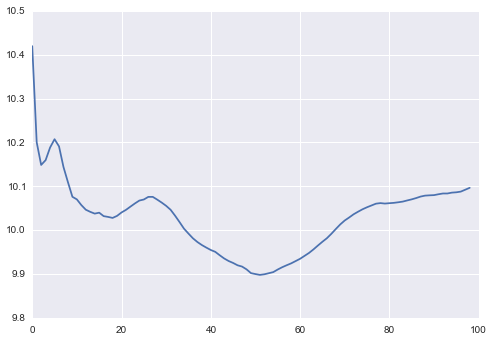

In [496]:
play_with_noise(.2)

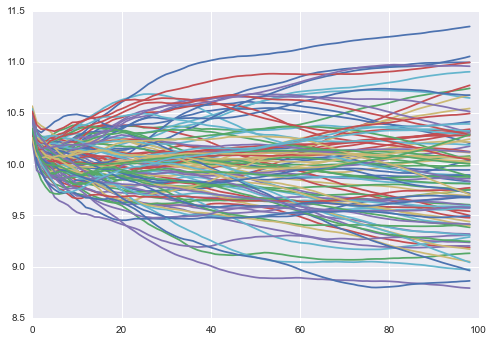

In [500]:
ls = []
bs = []
for i in range(100):
    a,b = play_with_noise(.2)
    ls.append(a)
    bs.append(b)

I needed a way to measure how much of the price movement was caused by short term noise. By trial and error I found that the ratio between the first and fourth datapoint provided a pretty accurate assessment. As you can see in the plot above, the first few values are similar but then they disperse. A ratio of 1.02 corresponds to 20% noise. 1.04 is 30%

In [502]:
print(np.mean(ls))
np.std(ls)

1.01907707414


0.0051872137912273315

In [503]:
print(np.mean(bs))
np.std(bs)

10.3938905329


0.06401362378943827

So by studying this model I have found that I need a ratio between 1-day and 4-day variance to be at least 1.03, which corresponds to about 20% noise in the signal. I can assume this indicator is reasonably strong since its standard deviation is only .01. 

I is worth noting that more experiments can be performed on this. I can chose 1-day to 4-day based on the graph, but a different combination might be more accurate. I also should try to select the optimal values of Q and R based on the amount of short-term noise detected in the variance ratio test. For now, I will move on and still use a constant.

## Fitting the Model to Real Data 

#### Single symbol

There is no proof that our intuitive model of random walk + white noise is valid. I believe that criterion for its success is a tendancy for some symbols to have a sudden drop at the begining of their "time window to variance curve," and for those symbols to tend to perform well with the simple "threshold" logic that I am using. 

In [504]:
def get_prices(symbol):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    #prices=np.asarray(list(prices))
    prices=prices.astype(float)
    return prices

In [505]:
# I experiment with GS here, feel free to try other symbols by typing them here and running the next few cells.
prices = get_prices('GS')

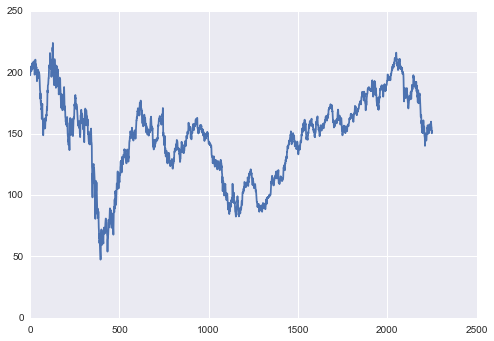

In [506]:
plot(prices)

In [507]:
stds = []
for i in range(1, 100):
    stds.append(np.std(prices- prices.shift(i)) * np.sqrt(1/i))

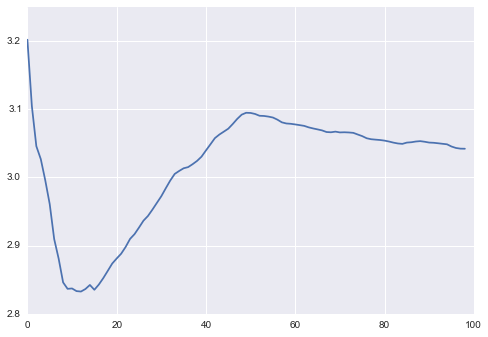

In [508]:
# The fact that this slopes downward strongly in the first few days (about 1-9 days) is a good sign. 
    # The rest of the curve is unimportant
plot(stds)

In [512]:
 # a value of 1.06 means that the noise is probably about 30% of the signal, a good sign
    # values lower than 1.03 will almost definitely not perform well
stds[0]/stds[1]        

1.0313645436857013

In [513]:
def get_results(prices):
    kf=KalmanFilter(transition_matrices=[[1,1],[0,1]],observation_matrices=[[1,0]],
                    initial_state_mean=[prices[0],0],transition_covariance=[[.001,0],[0,.001]],
                    observation_covariance=1) #TC -> Q ;; OC -> R
    # kf=kf.em(prices,n_iter=5)
    (a,b)=kf.filter(prices)
    test_data = pd.DataFrame(prices)
    test_data.columns = ['prices']
    test_data['signal'] = test_data
    test_data['filter'] = a[:,0]
    test_data['resids'] = test_data.prices - test_data['filter']
    test_data['position'] = 0
    resid_dev = np.std(test_data.resids)                         # lookahead bias 
    test_data.position[test_data.resids<-resid_dev] = 1
    test_data.position[test_data.resids>resid_dev] = -1
    test_data['daily_diff'] = (test_data.signal.shift(-1) - test_data.signal)/test_data.signal
    test_data['results'] = test_data.position * test_data.daily_diff
    return test_data
    

/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


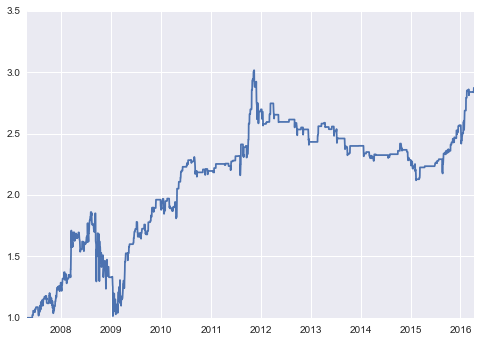

In [514]:
data = get_results(prices)
plot(data.index, np.cumprod(data.results + 1))

### multiple symbols

First we start out with a simple attempt, where we use the variance ratio of the entire price history to select which symbol we should use. This not only has lookahead bias, but is a crude method becuase is observes the data so broadly.

In [515]:
df = pd.read_pickle('../data/kal_returnsDF.pkl')
symbolsDF = pd.read_pickle('../data/symbolsDF.pkl')
sectors = symbolsDF.sector.unique().tolist()

In [454]:
start, end = '2007-05-02', '2016-04-11'                        #variable here
datadir_name = '_'.join(('data', start, end))
datadir_path = ''.join(('../data/', datadir_name))

In [516]:
# I get the variance ratio for each symbol
symbolsDF['std0'] = None
symbolsDF['variance_ratio'] = None
for symbol in symbolsDF.index:
    df = pd.read_pickle(''.join((datadir_path, '/', symbol, '.pkl')))
    prices = df['Adj Close']
    stds = []
    for i in range(1, 5):
        stds.append(np.std(prices- prices.shift(i)) * np.sqrt(1/i))
    ratio = stds[0]/stds[1]
    symbolsDF.loc[symbol,'std0'] = stds[0]
    symbolsDF.loc[symbol, 'variance_ratio'] = stds[0]/stds[1]

In [517]:
# I select symbols that have variance ratio greater than the mean of all variance ratios, which is 1.039
    # I end up with 236 symbols
print(symbolsDF.variance_ratio.mean())
use_symbols = symbolsDF.variance_ratio > symbolsDF.variance_ratio.mean()
print(sum(use_symbols))

1.0164253283
229


In [518]:
# I concatenate all results into one big data frame 
bigDF1 = pd.DataFrame()
for symbol in use_symbols[use_symbols==True].index:
    df = pd.read_pickle(''.join((datadir_path, '/', symbol, '.pkl')))
    prices = df['Adj Close']
    bigDF1[symbol] = get_results(prices).results

/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1.05472465248
0.0602091627934
0.908909042158


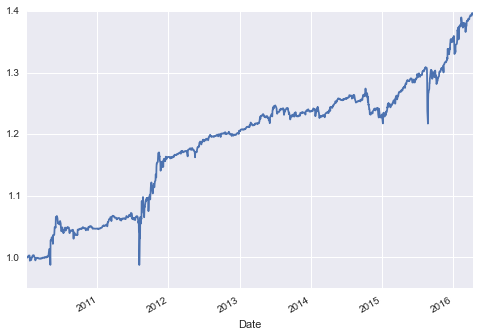

In [519]:
np.cumprod(bigDF1.mean(axis=1)['2010':] + 1).plot()

#results:
ann_return = np.cumprod(bigDF1.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF1.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)

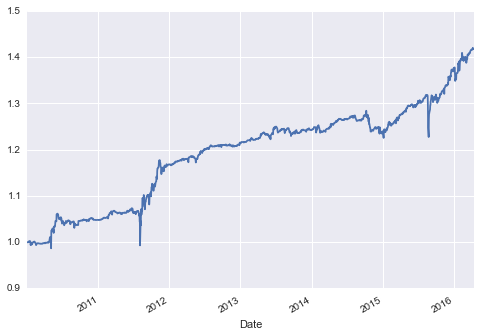

In [458]:
#old
np.cumprod(bigDF1.mean(axis=1)['2010':] + 1).plot()

#results:
ann_return = np.cumprod(bigDF1.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF1.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)

1.13017705338
0.139412201532
0.933756528862


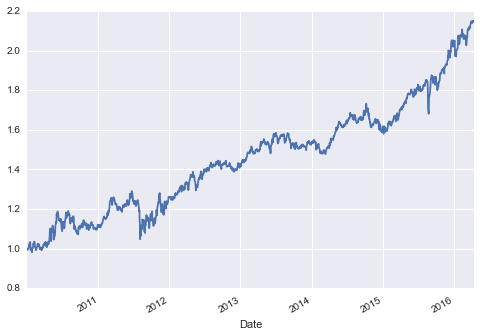

In [521]:
# I eliminate zero values to get a "fully allocated" version
bigDF2 = bigDF1.copy()
bigDF2[bigDF2 == 0 ] = None

np.cumprod(bigDF2.mean(axis=1)['2010':] + 1).plot()

# results:
ann_return = np.cumprod(bigDF2.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF2.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)

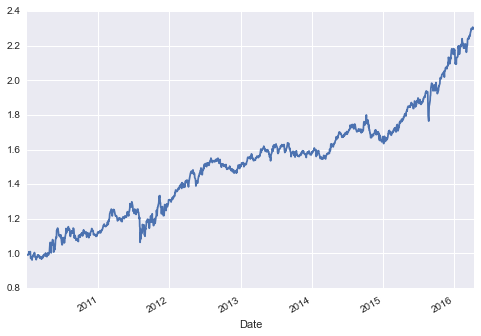

In [460]:
#old
# I eliminate zero values to get a "fully allocated" version
bigDF2 = bigDF1.copy()
bigDF2[bigDF2 == 0 ] = None

np.cumprod(bigDF2.mean(axis=1)['2010':] + 1).plot()

# results:
ann_return = np.cumprod(bigDF2.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF2.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)

### rolling var ratio

Now I want to get a more realistic picture of the variance ratio. I calculate it on a rolling basis with a window of 500 days

In [493]:
def get_xday_vol_ROLL(prices, x):
    vol = pd.rolling_apply((prices - prices.shift(x))/prices, 500, np.std) * np.sqrt(252/x)
    #vol = np.std((pricesDF - pricesDF.shift(-x))/pricesDF) * np.sqrt(252/x)
    return vol

def get_vol_ratio_ROLL(prices, x, y):
    return get_xday_vol_ROLL(prices, x)/get_xday_vol_ROLL(prices, y)

In [522]:

bigDF3 = pd.DataFrame()
varratDF = pd.DataFrame()
for symbol in symbolsDF.index:
    df = pd.read_pickle(''.join((datadir_path, '/', symbol, '.pkl')))
    prices = df['Adj Close']
    varratDF[symbol] = get_vol_ratio_ROLL(prices, 1, 2)
    bigDF3[symbol] = get_results(prices).results

/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1.0367600774
0.0610131854385
0.602493987748


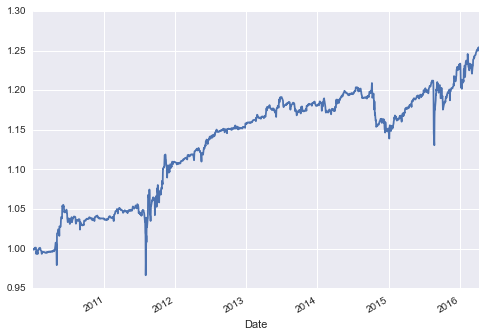

In [523]:
# the trade on all symbols regardless of variance ratio (control)
np.cumprod(bigDF3.mean(axis=1)['2010':] + 1).plot()
# results:
ann_return = np.cumprod(bigDF3.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF3.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)

1.0367600774
0.0610131854385
0.602493987748


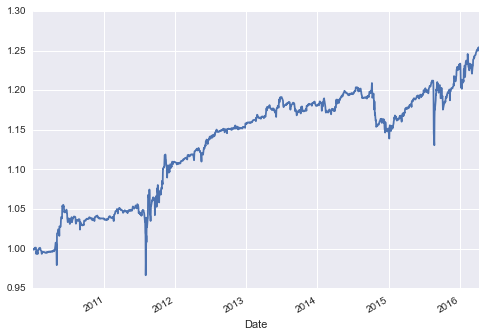

In [465]:
# old
# the trade on all symbols regardless of variance ratio (control)
np.cumprod(bigDF3.mean(axis=1)['2010':] + 1).plot()
# results:
ann_return = np.cumprod(bigDF3.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF3.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)

1.0112537454
0.0138402014358
0.813120058713


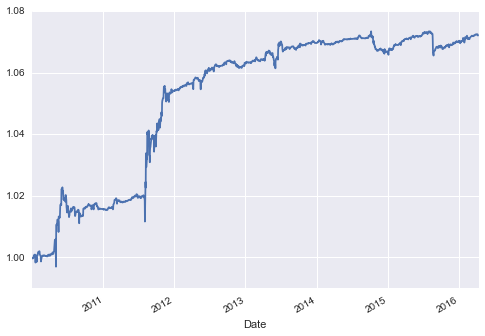

In [534]:
# only with variance ratio greater than 1.03 (20% noise)
bigDF4 = bigDF3.copy() #3333333333333333333 333
bigDF4 = (varratDF> 1.04) * bigDF4

np.cumprod(bigDF4.mean(axis=1)['2010':] + 1).plot()
# results:
ann_return = np.cumprod(bigDF4.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF4.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)

1.04118111222
0.028048871436
1.46819141423


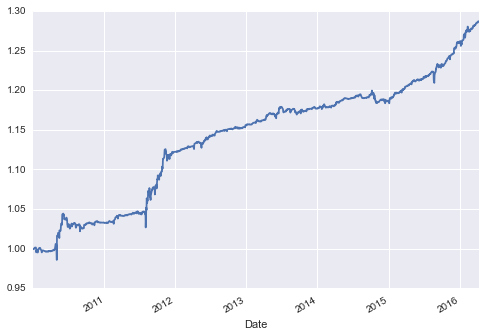

In [466]:
# old
# only with variance ratio greater than 1.03 (20% noise)
bigDF4 = bigDF3.copy() #3333333333333333333 333
bigDF4 = (varratDF> 1.03) * bigDF4

np.cumprod(bigDF4.mean(axis=1)['2010':] + 1).plot()
# results:
ann_return = np.cumprod(bigDF4.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF4.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)

1.13183069988
0.147039425281
0.896567023608


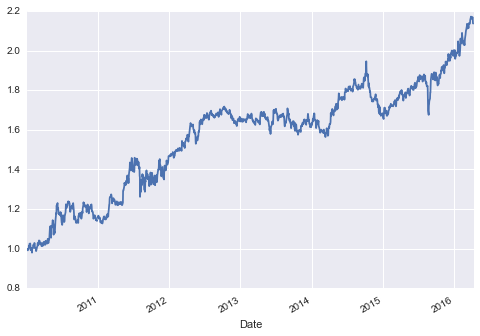

In [535]:
# fully allocated
bigDF5 = bigDF4.copy()
bigDF5[bigDF5 == 0 ] = None

np.cumprod(bigDF5.mean(axis=1)['2010':] + 1).plot()

# results:
ann_return = np.cumprod(bigDF5.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF5.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)

1.22487016429
0.136760595467
1.64426137164


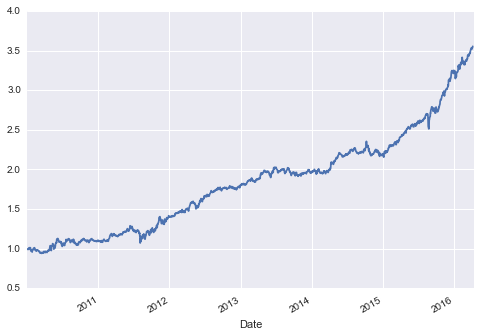

In [467]:
# old
# fully allocated
bigDF5 = bigDF4.copy()
bigDF5[bigDF5 == 0 ] = None

np.cumprod(bigDF5.mean(axis=1)['2010':] + 1).plot()

# results:
ann_return = np.cumprod(bigDF5.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF5.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)

In [536]:
(varratDF> 1.04).sum(axis=1)['2011':].mean() # average number of symbols 'in play' per day

90.0369532428356

In [537]:
504-(bigDF5.isnull())['2010':].sum(axis=1).mean() # avg positions per day

19.956273764258583

In [538]:
np.std(504-(bigDF5.isnull())['2010':].sum(axis=1)) # variance of # positions per day

19.96260735923653

Now without any lookahead...

In [478]:
def get_results2(prices):
    kf=KalmanFilter(transition_matrices=[[1,1],[0,1]],observation_matrices=[[1,0]],
                    initial_state_mean=[prices[0],0],transition_covariance=[[.001,0],[0,.001]],
                    observation_covariance=1) #TC -> Q ;; OC -> R
    # kf=kf.em(prices,n_iter=5)
    (a,b)=kf.filter(prices)
    test_data = pd.DataFrame(prices)
    test_data.columns = ['prices']
    test_data['signal'] = test_data
    test_data['filter'] = a[:,0]
    test_data['resids'] = test_data.prices - test_data['filter']
    test_data['position'] = 0
    test_data['resid_dev'] = pd.rolling_apply(test_data.resids, 50,  np.std)                 # lookahead bias 
    test_data.position[test_data.resids<-test_data.resid_dev] = 1
    test_data.position[test_data.resids>test_data.resid_dev] = -1
    test_data['daily_diff'] = (test_data.signal.shift(-1) - test_data.signal)/test_data.signal
    test_data['results'] = test_data.position * test_data.daily_diff
    return test_data
    

In [485]:

bigDF6 = pd.DataFrame()
varratDF = pd.DataFrame()
for symbol in symbolsDF.index:
    df = pd.read_pickle(''.join((datadir_path, '/', symbol, '.pkl')))
    prices = df['Adj Close']
    varratDF[symbol] = get_vol_ratio_ROLL(prices, 1, 4)
    bigDF6[symbol] = get_results2(prices).results

/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1.03586882586
0.0695744486618
0.515545958998


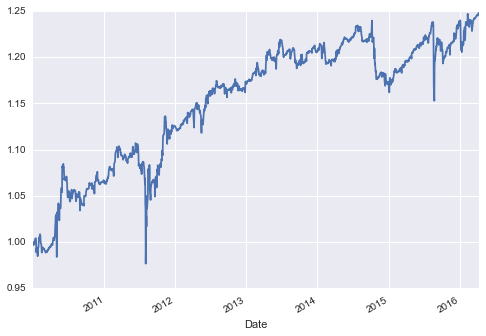

In [490]:
# the trade on all symbols regardless of variance ratio (control)
np.cumprod(bigDF6.mean(axis=1)['2010':] + 1).plot()
# results:
ann_return = np.cumprod(bigDF6.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF6.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)

1.04655993249
0.0355051144676
1.31135846737


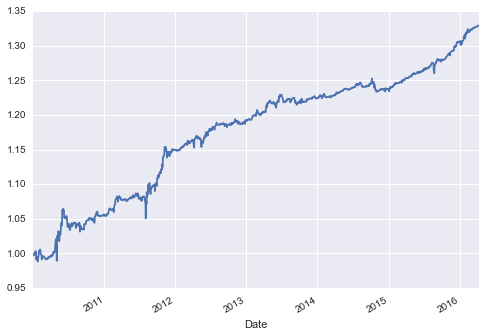

In [491]:
# only with variance ratio greater than 1.03 (20% noise)
bigDF7 = bigDF6.copy() #3333333333333333333 333
bigDF7 = (varratDF> 1.03) * bigDF7

np.cumprod(bigDF7.mean(axis=1)['2010':] + 1).plot()
# results:
ann_return = np.cumprod(bigDF7.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF7.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)

1.22585938723
0.130319842001
1.73311587679


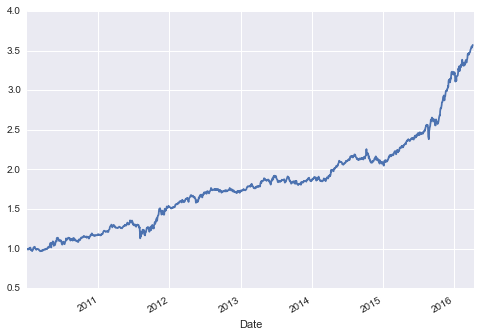

In [492]:
# fully allocated
bigDF8 = bigDF7.copy()
bigDF8[bigDF8 == 0 ] = None

np.cumprod(bigDF8.mean(axis=1)['2010':] + 1).plot()

# results:
ann_return = np.cumprod(bigDF8.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF8.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)

/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1.03586882586
0.0695744486618
0.515545958998


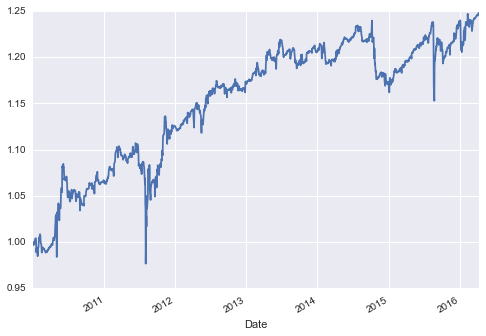

1.01875996733
0.0345076928283
0.543645946606


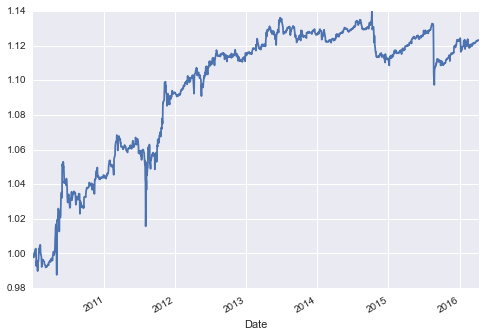

1.05727102705
0.12870707701
0.444971856859


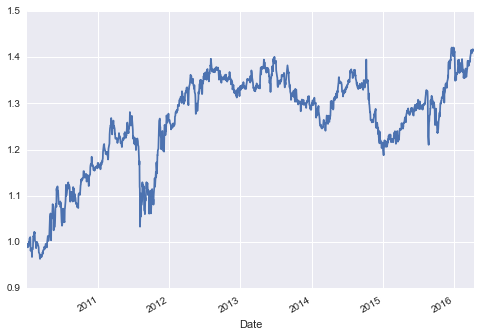

In [494]:

bigDF6 = pd.DataFrame()
varratDF = pd.DataFrame()
for symbol in symbolsDF.index:
    df = pd.read_pickle(''.join((datadir_path, '/', symbol, '.pkl')))
    prices = df['Adj Close']
    varratDF[symbol] = get_vol_ratio_ROLL(prices, 1, 4)
    bigDF6[symbol] = get_results2(prices).results
    
# the trade on all symbols regardless of variance ratio (control)
np.cumprod(bigDF6.mean(axis=1)['2010':] + 1).plot()
# results:
ann_return = np.cumprod(bigDF6.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF6.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)
show()

# only with variance ratio greater than 1.03 (20% noise)
bigDF7 = bigDF6.copy() #3333333333333333333 333
bigDF7 = (varratDF> 1.03) * bigDF7

np.cumprod(bigDF7.mean(axis=1)['2010':] + 1).plot()
# results:
ann_return = np.cumprod(bigDF7.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF7.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)
show()

# fully allocated
bigDF8 = bigDF7.copy()
bigDF8[bigDF8 == 0 ] = None

np.cumprod(bigDF8.mean(axis=1)['2010':] + 1).plot()

# results:
ann_return = np.cumprod(bigDF8.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF8.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)
show()

/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1.03586882586
0.0695744486618
0.515545958998


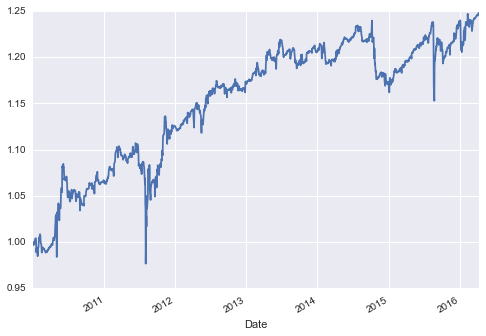

1.01831952544
0.0229875927518
0.796931006797


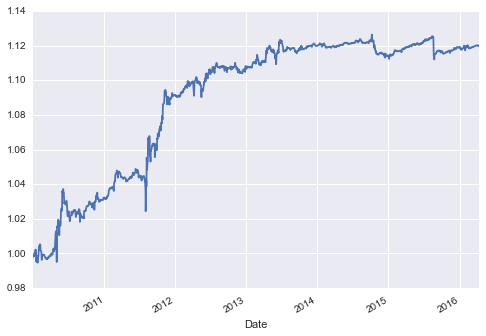

1.0950883451
0.13054027033
0.728421542747


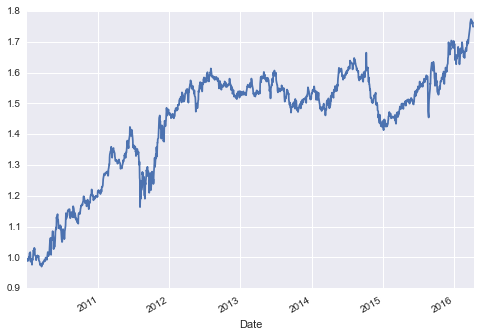

In [539]:

bigDF6 = pd.DataFrame()
varratDF = pd.DataFrame()
for symbol in symbolsDF.index:
    df = pd.read_pickle(''.join((datadir_path, '/', symbol, '.pkl')))
    prices = df['Adj Close']
    varratDF[symbol] = get_vol_ratio_ROLL(prices, 1, 2)
    bigDF6[symbol] = get_results2(prices).results
    
# the trade on all symbols regardless of variance ratio (control)
np.cumprod(bigDF6.mean(axis=1)['2010':] + 1).plot()
# results:
ann_return = np.cumprod(bigDF6.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF6.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)
show()

# only with variance ratio greater than 1.03 (20% noise)
bigDF7 = bigDF6.copy() #3333333333333333333 333
bigDF7 = (varratDF> 1.03) * bigDF7

np.cumprod(bigDF7.mean(axis=1)['2010':] + 1).plot()
# results:
ann_return = np.cumprod(bigDF7.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF7.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)
show()

# fully allocated
bigDF8 = bigDF7.copy()
bigDF8[bigDF8 == 0 ] = None

np.cumprod(bigDF8.mean(axis=1)['2010':] + 1).plot()

# results:
ann_return = np.cumprod(bigDF8.mean(axis=1)['2010':] + 1)[-5] ** (1/6.25)
ann_vol = np.std(bigDF8.mean(axis=1)['2010':]) * np.sqrt(252)
sharpe = (ann_return-1) / ann_vol
print(ann_return)
print(ann_vol)
print(sharpe)
show()

In [479]:
prices = get_prices('GS')

In [481]:
dd = get_results2(prices)

/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/liamconnell/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


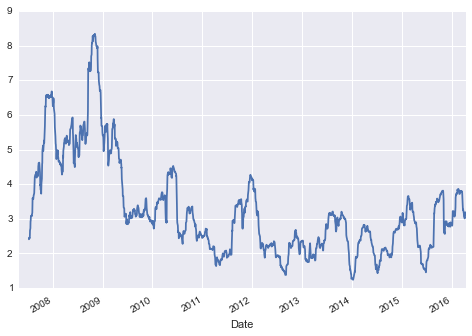

In [482]:
dd.resid_dev.plot()

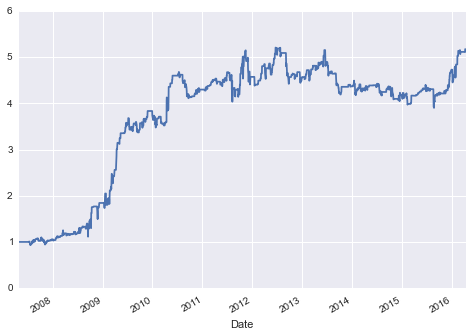

In [484]:
np.cumprod(dd.results + 1).plot()